In [30]:
import numpy as np

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

import skimage
from PIL import Image
from datetime import datetime

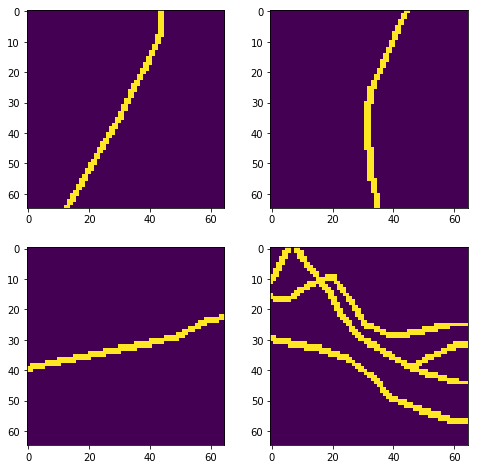

In [61]:
# Read and preprocess an example batch of images.
d = 65 # the image dimension

imfiles = ["debug/patch_and_label_0_2654_1785.png",
          "debug/patch_and_label_0_2731_2893.png",
          "debug/patch_and_label_0_3147_4232.png",
          "debug/patch_and_label_0_3609_4309.png"]
imlist = [Image.open(f) for f in imfiles]
imlist = [im.convert("L").crop((65, 0, 130, 65)).resize((d,d)) for im in imlist]
imlist = [np.array(im) for im in imlist]
imlist = [im / 255. for im in imlist]


rows = 2  # nrows in subplot
columns = 2  # ncols in subplot

# Plot each element in the batch.
fig=pl.figure(figsize=(8, 8))
for i in range(1, rows*columns + 1):
    im = imlist[i-1]
    y = np.array(im)
    fig.add_subplot(rows, columns, i)
    pl.imshow(y)


In [138]:
def make_noisy_image(y, d=d, shift=20):
    """A function to make a noisy version of an image."""
    y_hat = np.hstack((np.zeros((d,shift)), y[:, :-shift]))
    y_hat[30:40, :] = 0.  # zero out a strip of the image
    y_hat[20:22] = 1.  # add a line in the image

    y_hat /= y_hat.max()  # normalize prior to adding noise
    y_hat = skimage.util.random_noise(y_hat, var=0.1)
    y_hat /= y_hat.max()
    return y_hat

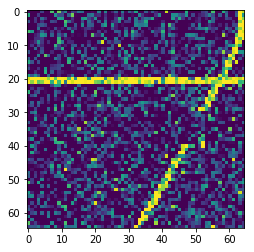

In [139]:
y = imlist[0]
y_hat = make_noisy_image(y)
pl.imshow(y_hat)

In [140]:
y = y.astype(np.float64)
y_hat = y_hat.astype(np.float64)

In [141]:
from fftracer.training.loss import compute_ot_loss_matrix, make_distance_matrix
D = make_distance_matrix(y.shape[0])

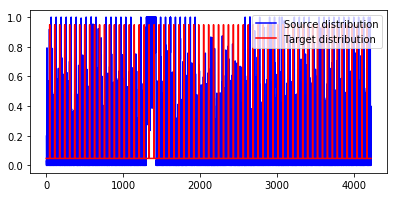

In [142]:
#%% plot the distributions
n = d**2
x = np.arange(n, dtype=np.float64)
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, y_hat.flatten(), 'b', label='Source distribution')
pl.plot(x, y.flatten(), 'r', label='Target distribution')
pl.legend()

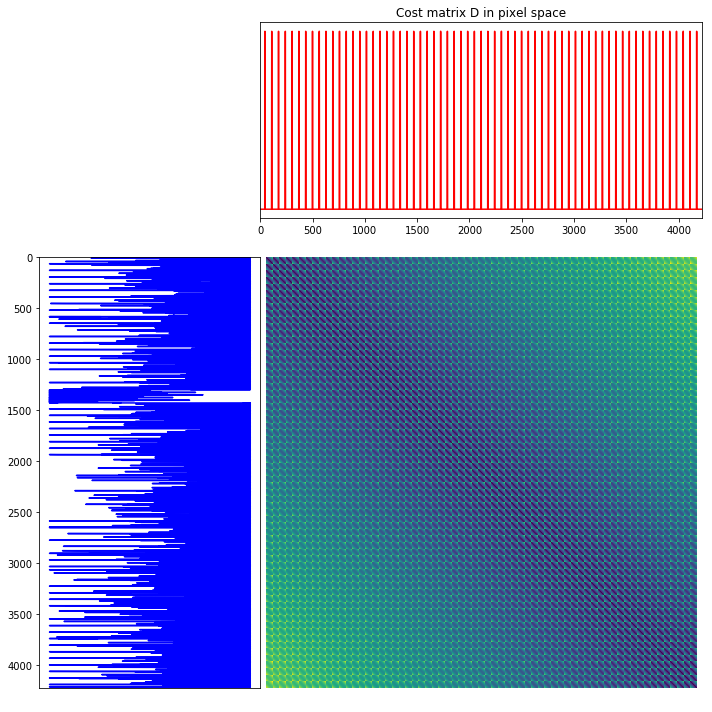

In [143]:
# plot distributions and loss matrix
pl.figure(2, figsize=(10, 10))
ot.plot.plot1D_mat(y_hat.flatten(), y.flatten(), D, 'Cost matrix D in pixel space')

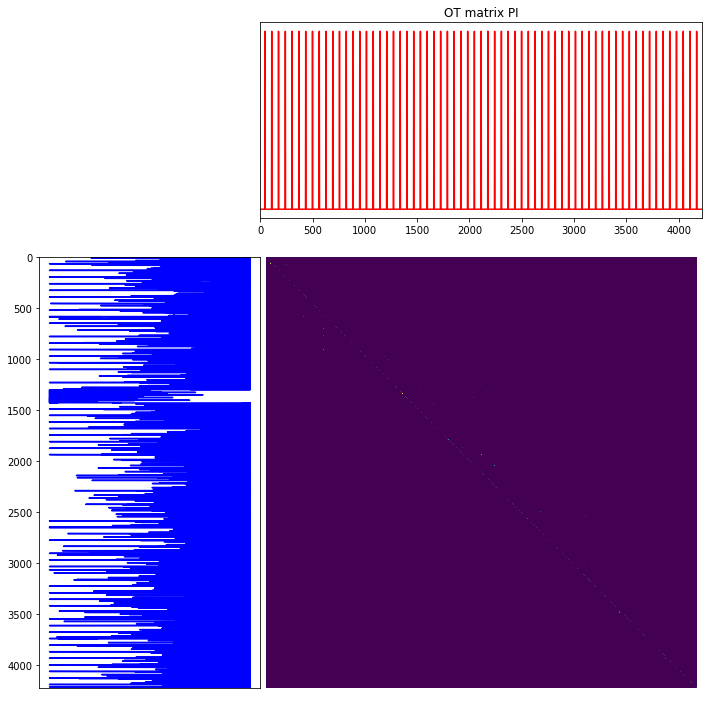

In [144]:
# solve the ot problem and show the result with source/target distributions
PI = compute_ot_loss_matrix(y, y_hat, D)

pl.figure(3, figsize=(10,10))
ot.plot.plot1D_mat(y_hat.flatten(), y.flatten(), PI, 'OT matrix PI')

In [145]:
PI.max()

0.0012917278688630378

Text(0.5, 1.0, 'Pi, optimal transport permutation matrix')

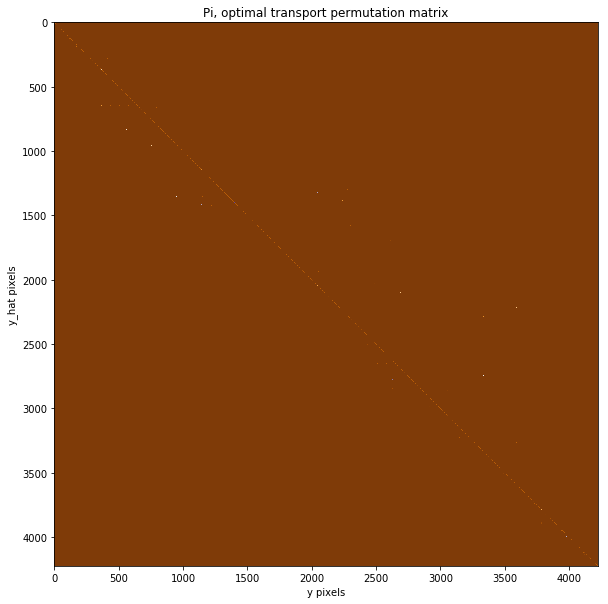

In [146]:
pl.figure(figsize=(10,10))
pl.imshow(PI, cmap="PuOr")
pl.ylabel("y_hat pixels")
pl.xlabel("y pixels")
pl.title("Pi, optimal transport permutation matrix")

In [147]:
from fftracer.training.loss import compute_pixel_loss

In [148]:
def compute_alpha(y: np.ndarray, y_hat: np.ndarray):
    A = y.astype(np.float64).sum()
    print("A: %4f" % A)
    B = y_hat.astype(np.float64).sum()
    print("B: %4f" % B)
    alpha = B / (2.0 * A)
    print("B / 2A: %6f" % alpha)
    alpha = min(alpha, 1.0)
    print("alpha = %5f" % alpha)
    return alpha

In [151]:
alpha = compute_alpha(y, y_hat)
pixel_loss = compute_pixel_loss(PI, D, alpha=alpha)

A: 330.509804
B: 774.156867
B / 2A: 1.171156
alpha = 1.000000


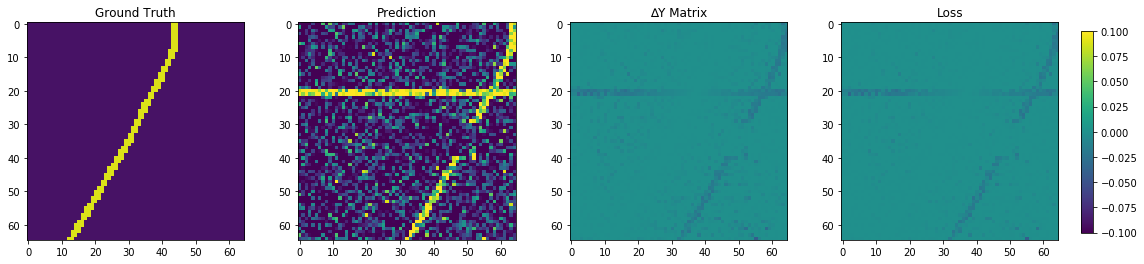

In [177]:
# Plot the ground truth, prediction, ∆y, and pixelwise loss matrix
val_args={"vmin":-0.5, "vmax": 0.5}
alpha_grid = [0, 0.1, 0.25, 0.5 ,0.75, 0.9, 1]
fig, ax = pl.subplots(nrows=1, ncols=4)
ax[0].imshow(y, vmin=0, vmax=1)
ax[0].set_title("Ground Truth")
ax[1].imshow(y_hat, vmin=0, vmax=1)
ax[1].set_title("Prediction")
ax[2].imshow(pixel_loss, vmin=-0.1, vmax=0.1)
ax[2].set_title("∆Y Matrix")
ax[3].imshow(y_hat * pixel_loss, vmin=-0.1, vmax=0.1)
ax[3].set_title("Loss")



fig.subplots_adjust(right=0.975)
cbar_ax = fig.add_axes([0.99, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.set_figheight(4)
fig.set_figwidth(17)
pl.show()

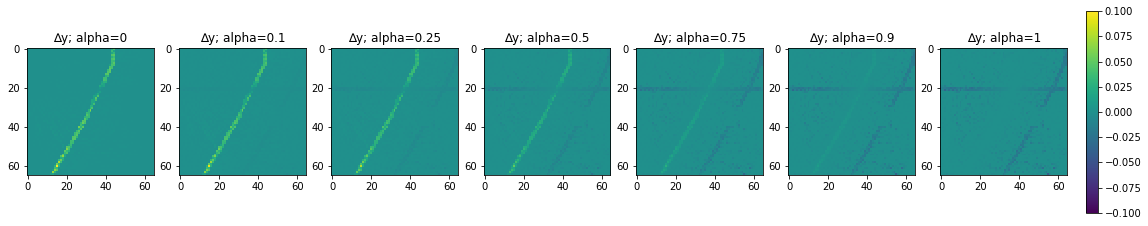

In [174]:
alpha_grid = [0, 0.1, 0.25, 0.5 ,0.75, 0.9, 1]
fig, axes = pl.subplots(nrows=1, ncols=len(alpha_grid))
for i,ax in enumerate(axes.flat):
    alpha=alpha_grid[i]
    pixel_loss = compute_pixel_loss(PI, D, alpha=alpha)  
    im = ax.imshow(pixel_loss, vmin=-0.1, vmax=0.1)
    ax.set_title("∆y; alpha=%s" % alpha)

fig.subplots_adjust(right=0.975)
cbar_ax = fig.add_axes([0.99, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.set_figheight(4)
fig.set_figwidth(17)
pl.show()

# Batch example

In [45]:
y_batch = np.array(imlist)
y_batch = np.expand_dims(y_batch, axis=3)  # add a channels dim to simulate ffn training batches
print(y_batch.shape)

(4, 65, 65, 1)


In [46]:
y_hat_batch = [make_noisy_image(y_batch[i,:,:,0]) for i in range(y_batch.shape[0])]
y_hat_batch = np.array(y_hat_batch)
y_hat_batch = np.expand_dims(y_hat_batch, 3)
y_hat_batch.shape

(4, 65, 65, 1)

In [47]:
from fftracer.training.loss import compute_ot_loss_matrix_batch, compute_pixel_loss_batch
pi_batch = compute_ot_loss_matrix_batch(y_batch, y_hat_batch, D)

In [48]:
print(pi_batch.shape)

(4, 4225, 4225)


In [49]:
# compute the alpha
alpha = compute_alpha_batch(y_batch, y_hat_batch)
print("alpha: {}".format(alpha))

batch_pixel_loss = compute_pixel_loss_batch(pi_batch, alpha, D)
batch_pixel_loss = np.array(batch_pixel_loss)

alpha: [0.5 0.5 0.5 0.5]


In [50]:
batch_pixel_loss.shape

(4, 65, 65)

In [51]:
i=1
batch_pixel_loss[i-1, :, :].shape

(65, 65)

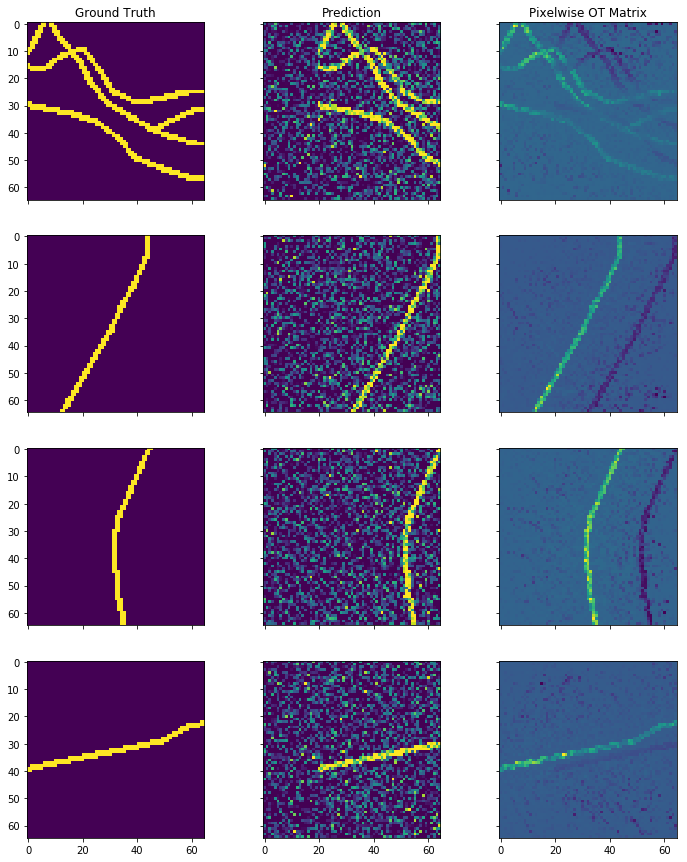

In [52]:
# Plot the loss for each element in the batch.
fig, axs = pl.subplots(4, 3)
fig.set_figheight(15)
fig.set_figwidth(12)
for i in range(0, 4):    
    axs[i,0].imshow(y_batch[i-1, :, :, 0])
    if i == 0:
        axs[i,0].set_title("Ground Truth")
    axs[i,1].imshow(y_hat_batch[i-1, :, :, 0])
    if i == 0:
        axs[i,1].set_title("Prediction")
    axs[i,2].imshow(batch_pixel_loss[i-1, :, :])
    if i == 0:
        axs[i,2].set_title("Pixelwise OT Matrix")

# add shared axes
for ax in fig.get_axes():
    ax.label_outer()


In [53]:
# solve the ot problem and show the result with source/target distributions
i=0
PI_i = compute_ot_loss_matrix(y_batch[i, :, :, 0], y_hat_batch[i, :, :, 0], D)
pixel_loss = compute_pixel_loss(PI_i, D)

Text(0.5, 1.0, 'Pixelwise OT Matrix')

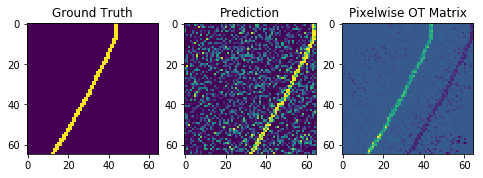

In [54]:
# Plot the loss for each element in the batch.
fig=pl.figure(figsize=(8, 8))
fig.add_subplot(1, 3, 1)
pl.imshow(y_batch[i, :, :, 0])
pl.title("Ground Truth")
fig.add_subplot(1, 3, 2)
pl.imshow(y_hat_batch[i, :, :, 0])
pl.title("Prediction")
fig.add_subplot(1, 3, 3)
pl.imshow(pixel_loss)
pl.title("Pixelwise OT Matrix")

In [55]:
y_batch.shape

(4, 65, 65, 1)